#### Importando Bibliotecas

In [1]:
# manipulação de dados
import pandas as pd
import numpy as np

# gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# modelo de prvisão
import plotly.express as px
from scipy.stats import kruskal

## Tratamento preliminar de dados

#### Carrgando Dados

In [2]:
df_main = pd.read_csv("teste_indicium_precificacao.csv")

In [3]:
df_main.head(2)

id                                 nome  host_id  host_name bairro_group  \
0  2595                Skylit Midtown Castle     2845   Jennifer    Manhattan   
1  3647  THE VILLAGE OF HARLEM....NEW YORK !     4632  Elisabeth    Manhattan   

    bairro  latitude  longitude        room_type  price  minimo_noites  \
0  Midtown  40.75362  -73.98377  Entire home/apt    225              1   
1   Harlem  40.80902  -73.94190     Private room    150              3   

   numero_de_reviews ultima_review  reviews_por_mes  \
0                 45    2019-05-21             0.38   
1                  0           NaN              NaN   

   calculado_host_listings_count  disponibilidade_365  
0                              2                  355  
1                              1                  365

In [4]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

#### Lidando com Valores Ausentes

In [5]:
df_main.isnull().sum()[df_main.isnull().sum() > 0]/df_main.shape[0] * 100

nome                0.032724
host_name           0.042950
ultima_review      20.558760
reviews_por_mes    20.558760
dtype: float64

As colunas nome, host_name, ultima_review e reviews_por_mes possuem valores ausentes, a abordagem para cada coluna será a seguinte:

nome: substituir por unknown (são poucos valores) 

host_name: substituir por unknown

ultima_review: remover, pois corresponde a 20% dos dados

reviews_por_mes: remover, pois corresponde a 20% dos dados

In [6]:
df_main.drop(['ultima_review', 'reviews_por_mes'], inplace=True, axis=1)

In [7]:
df_main['nome'].fillna('unknown', inplace=True)
df_main['host_name'].fillna('unknown', inplace=True)

#### Lidando com Outliers

In [8]:
df_main.describe()

id       host_id      latitude     longitude         price  \
count  4.889400e+04  4.889400e+04  48894.000000  48894.000000  48894.000000   
mean   1.901753e+07  6.762139e+07     40.728951    -73.952169    152.720763   
std    1.098288e+07  7.861118e+07      0.054529      0.046157    240.156625   
min    2.595000e+03  2.438000e+03     40.499790    -74.244420      0.000000   
25%    9.472371e+06  7.822737e+06     40.690100    -73.983070     69.000000   
50%    1.967743e+07  3.079553e+07     40.723075    -73.955680    106.000000   
75%    2.915225e+07  1.074344e+08     40.763117    -73.936273    175.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990  10000.000000   

       minimo_noites  numero_de_reviews  calculado_host_listings_count  \
count   48894.000000       48894.000000                   48894.000000   
mean        7.030085          23.274758                       7.144005   
std        20.510741          44.550991                      32.952855   
min         1.000000           0.000000                       1.000000   
25%         1.000000           1.000000                       1.000000   
50%         3.000000           5.000000                       1.000000   
75%         5.000000          24.000000                       2.000000   
max      1250.000000         629.000000                     327.000000   

       disponibilidade_365  
count         48894.000000  
mean            112.776169  
std             131.618692  
min               0.000000  
25%               0.000000  
50%              45.000000  
75%             227.000000  
max             365.000000

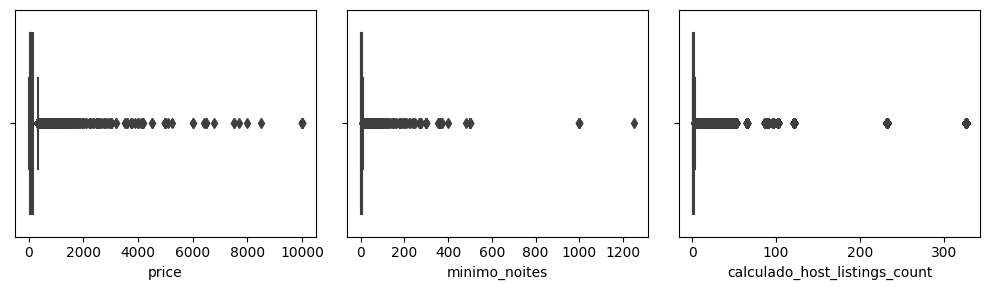

In [9]:
max_linhas = 1
max_colunas = 3
linha = 0
coluna = 0

fig, ax = plt.subplots(max_linhas, max_colunas , figsize=(10, 3))

for coluna_n in ['price', 'minimo_noites', 'calculado_host_listings_count']:
    
    sns.boxplot(data=df_main, x=coluna_n, ax=ax[coluna]) # usar [linha, coluna] quando tiver mais de 1 linha
    
    coluna += 1
    
    if coluna == max_colunas:
        linha += 1
        coluna = 0
        
plt.tight_layout()
plt.show()

Observando os conjunto de dados, é possível observar alguns outliers:

price: contem valores que vão até 10000

minimo_noites; contem valores que vão até 1250

calculado_host_listings_count: contem valores que vão até 327

embora esses dados possam ser reais, eles difcultam a análise, por isso serão retirados usando o **método do intervalo interquartil** . (posteriormente, caso necessário, lido com eles)

<hr style="border: 1px solid black">

Antes de tratar os outliers, é possível observar que os outlier de price são porvenientes de uma determinado região de Manhattan, que é uma cidade cara e por isso o aluguél deve ser mais caro, observe o gráfico abaixo (pontos verde)

In [10]:
Q1 = df_main['price'].quantile(0.25)
Q3 = df_main['price'].quantile(0.75)
IQR = Q3 - Q1

price_limite_superior = Q3 + (IQR * 1.5)

print(f'limite superior de price: {price_limite_superior}')

# este limite superior esta sendo definido para analisar os dados de forma mais fácil

limite superior de price: 334.0


In [11]:
# Localização de aluguéis sem outliers

fig = px.scatter_mapbox(df_main[df_main['price'] < price_limite_superior], lat='latitude', lon='longitude', color="price")
fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [12]:
# Localização de aluguéis com outliers, aqui está a região que apresenta os maiores valores price

fig = px.scatter_mapbox(df_main[df_main['price'] > price_limite_superior], lat='latitude', lon='longitude', color="price")
fig.update_layout(mapbox_style="open-street-map")
fig.show()

Removendo outliers:

In [13]:
# Só clique Run 1 vez, caso contrário altera os dados

limites = []

for coluna_n in ['price', 'minimo_noites', 'calculado_host_listings_count']:
    Q1 = df_main[coluna_n].quantile(0.25)
    Q3 = df_main[coluna_n].quantile(0.75)
    
    IQR = Q3 - Q1
    
    limite_inferior = Q1 - (IQR * 1.5)
    limite_superior = Q3 + (IQR * 1.5)
    
    
    
    dic = {'coluna_n': coluna_n, 'limite_inferior': limite_inferior, 'limite_superior': limite_superior, 'quantidade acima do limite superior': df_main[df_main[coluna_n] > limite_superior][coluna_n].count()}
    limites.append(dic)
    
    df_main = df_main[df_main[coluna_n] < limite_superior]

pd.DataFrame(limites)

coluna_n  limite_inferior  limite_superior  \
0                          price            -90.0            334.0   
1                  minimo_noites             -5.0             11.0   
2  calculado_host_listings_count             -0.5              3.5   

   quantidade acima do limite superior  
0                                 2972  
1                                 6181  
2                                 3755

## EDA

#### Avaliando preço por bairro_group

In [14]:
df_main['bairro_group'].value_counts()

Brooklyn         15894
Manhattan        14769
Queens            4168
Bronx              837
Staten Island      283
Name: bairro_group, dtype: int64

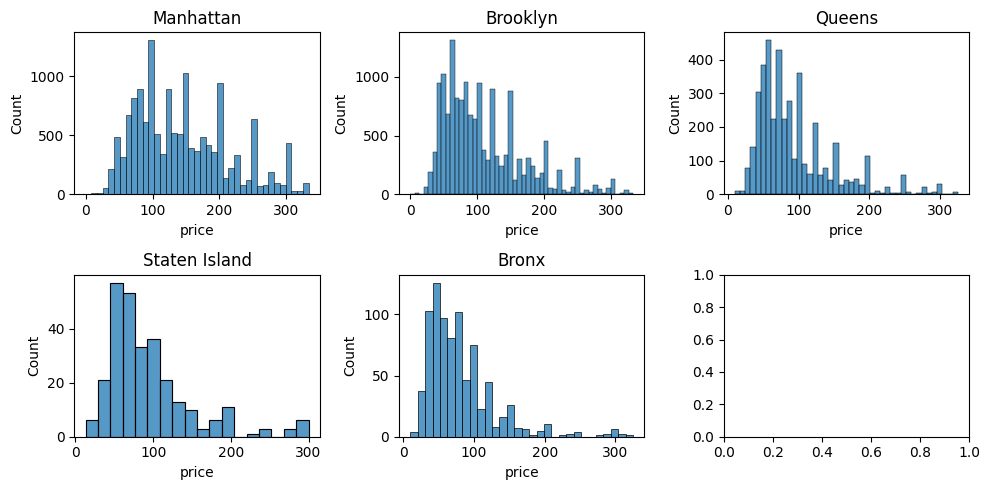

In [15]:
max_linhas = 2
max_colunas = 3
linha = 0
coluna = 0

coluna_de_analise = 'price'
coluna_de_segmentacao = 'bairro_group'

fig, ax = plt.subplots(max_linhas, max_colunas , figsize=(10, 5))

for coluna_n in df_main[coluna_de_segmentacao].unique():
    
    sns.histplot(data=df_main[df_main[coluna_de_segmentacao] == coluna_n], x=coluna_de_analise, ax=ax[linha, coluna]) # usar [linha, coluna] quando tiver mais de 1 linha
    ax[linha, coluna].set_title(coluna_n)
    
    coluna += 1
    
    if coluna == max_colunas:
        linha += 1
        coluna = 0
        
plt.tight_layout()
plt.show()

**Manhattan e Brooklyn** são os bairros com maior quantidade de imóveis/quartos para alugar, além disso apresentam maior diversidade de preço, possuindo mais imóveis/quartos de aluguél mais caros se comparado ao Queens, Staten Island e Bronx, Isso pode demosntrar que **Manhattan e Brookly** podem ser mais receptíveis a aluguéis mais caros se comparado aos outros bairros.

#### preço por room_type

A maioria dos aluguéis são Entire home/apt e Private room

os **Entire home/apt** possuem boa diversificação de preço, porém quando se **trata de Private room e Shared room** observa-se que esses são a minoria quando o valor tende a ser maior que 200, isso pode dificultar a inclusão de aluguéis mais caros para esses tipos de quarto devido a concorrência dos aluguéis mais baratos

In [16]:
df_main['room_type'].value_counts()

Entire home/apt    18143
Private room       17168
Shared room          640
Name: room_type, dtype: int64

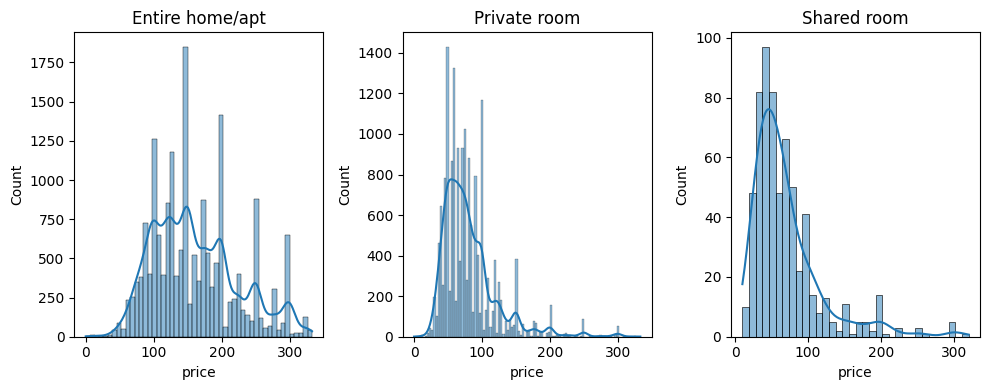

In [17]:
max_linhas = 1
max_colunas = 3
linha = 0
coluna = 0

coluna_de_analise = 'price'
coluna_de_segmentacao = 'room_type'

fig, ax = plt.subplots(max_linhas, max_colunas , figsize=(10, 4))

for coluna_n in df_main[coluna_de_segmentacao].unique():
    
    sns.histplot(data=df_main[df_main[coluna_de_segmentacao] == coluna_n], x=coluna_de_analise, ax=ax[coluna], kde=True) # usar [linha, coluna] quando tiver mais de 1 linha
    ax[coluna].set_title(coluna_n)
    
    coluna += 1
    
    if coluna == max_colunas:
        linha += 1
        coluna = 0
        
plt.tight_layout()
plt.show()

Além disso, quando observamos o preço dos aluguéis por **room_type** e **bairro_group**, observamos que Manhattan tem os aluguéis mais caros, independente do tipo de imóvel/quarto.

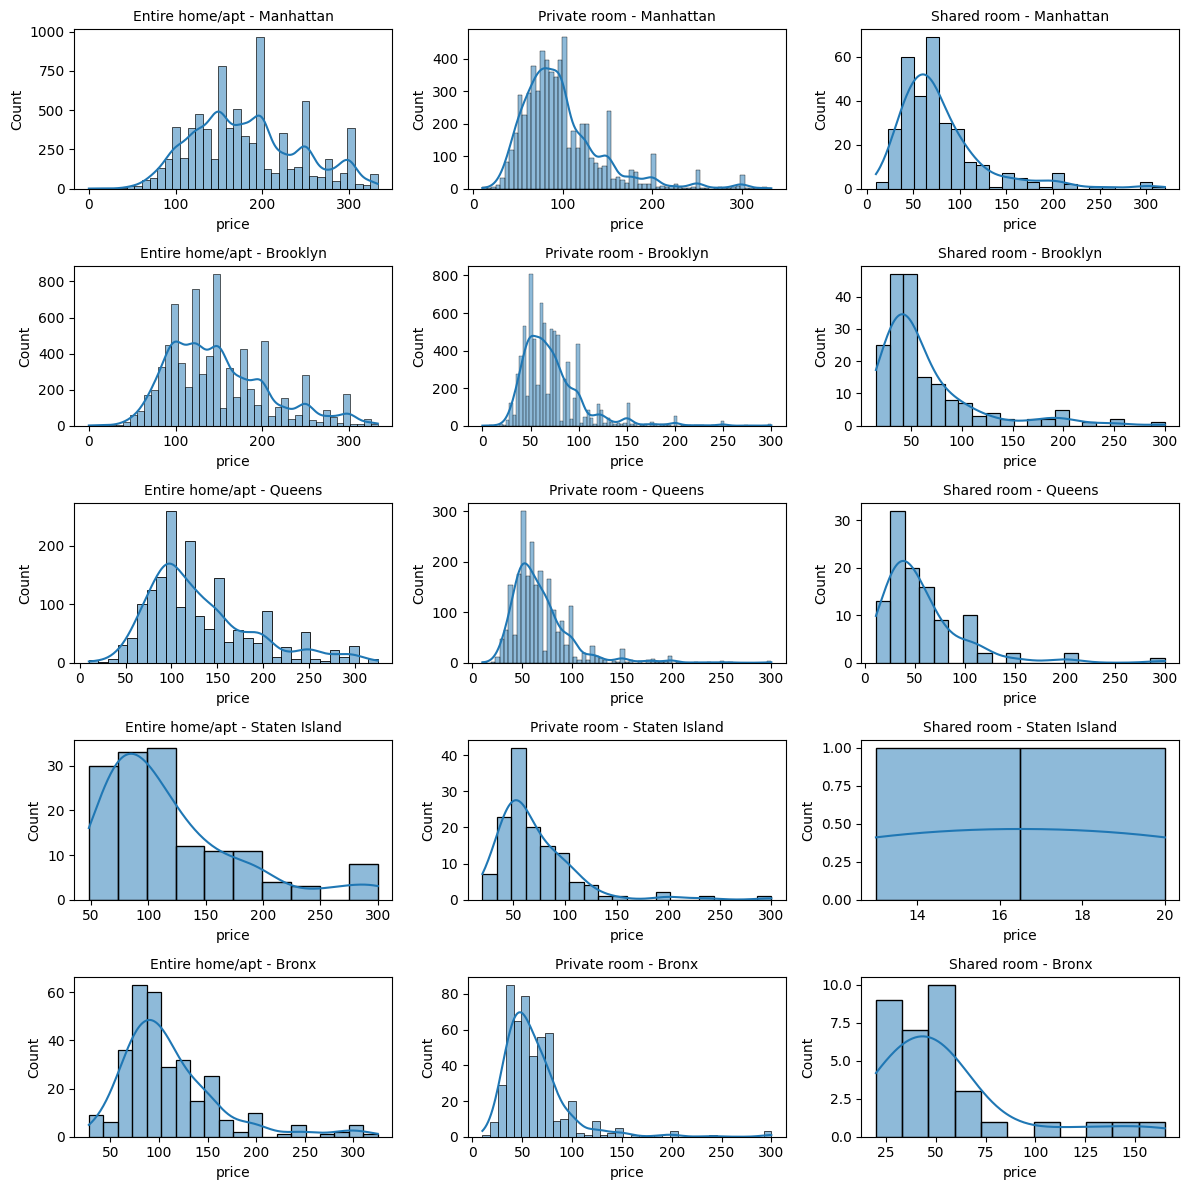

In [18]:
linhas = 5
colunas = 3
coluna_de_plotagem = 0
coluna_de_análise = 'room_type'

fig, ax = plt.subplots(linhas, colunas , figsize=(12, 12))

for bairro_name in enumerate(df_main['bairro_group'].unique()):

    for bairro in enumerate(df_main[coluna_de_análise].unique()):

        sns.histplot(data=df_main[(df_main[coluna_de_análise] == bairro[1]) & (df_main['bairro_group'] == bairro_name[1])]['price'], ax=ax[bairro_name[0], coluna_de_plotagem], kde=True)
        ax[bairro_name[0], coluna_de_plotagem].set_title(bairro[1] + ' - ' + bairro_name[1], fontsize=10)
        #mediana = df_main[(df_main[coluna_de_análise] == bairro[1])]['price'].median()
        #ax[bairro_name[0], coluna_de_plotagem].axvline(mediana, color='red')

        coluna_de_plotagem += 1

        if coluna_de_plotagem == colunas:
            coluna_de_plotagem = 0


plt.tight_layout()

#### Relação de Disponibilidade de Reserva com room_type e bairro_group

Avaliando quantos imóveis tem muita disponibilidade durante o ano, isso será feito para indicar locais e room_type que são pouco alugados

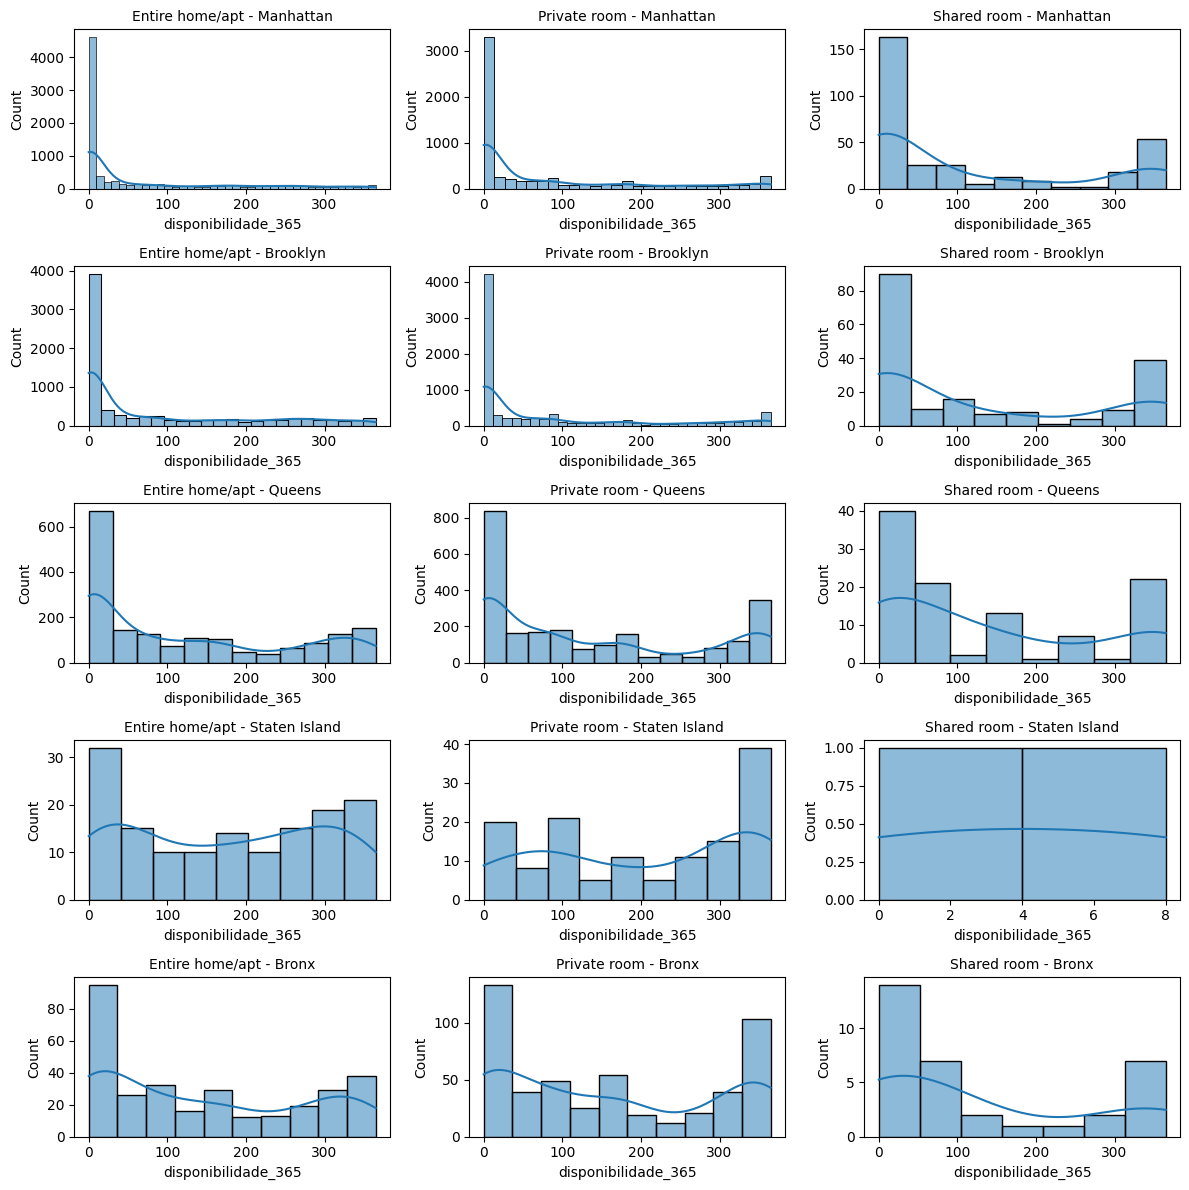

In [19]:
linhas = 5
colunas = 3
coluna_de_plotagem = 0
coluna_de_análise = 'room_type'

fig, ax = plt.subplots(linhas, colunas , figsize=(12, 12))

for bairro_name in enumerate(df_main['bairro_group'].unique()):

    for bairro in enumerate(df_main[coluna_de_análise].unique()):

        sns.histplot(data=df_main[(df_main[coluna_de_análise] == bairro[1]) & (df_main['bairro_group'] == bairro_name[1])]['disponibilidade_365'], ax=ax[bairro_name[0], coluna_de_plotagem], kde=True)
        ax[bairro_name[0], coluna_de_plotagem].set_title(bairro[1] + ' - ' + bairro_name[1], fontsize=10)
        #mediana = df_main[(df_main[coluna_de_análise] == bairro[1])]['price'].median()
        #ax[bairro_name[0], coluna_de_plotagem].axvline(mediana, color='red')

        coluna_de_plotagem += 1

        if coluna_de_plotagem == colunas:
            coluna_de_plotagem = 0


plt.tight_layout()

porcentagem de imóveis disponíveis por mais de 100 dias e menos de 100

In [20]:
threshold_de_disponibilidade = 100

In [21]:
df_disponibilidade = pd.DataFrame(df_main.groupby(by=['bairro_group', 'room_type'])['disponibilidade_365'].agg(
    disponível_menos_de_100 = lambda x: (x < threshold_de_disponibilidade).sum(),
    disponível_mais_de_100 = lambda x: (x >= threshold_de_disponibilidade).sum()))

df_disponibilidade['Porcentagem_com_disponibilidade_acima_de_100'] = (df_disponibilidade['disponível_mais_de_100']/(df_disponibilidade['disponível_menos_de_100']+df_disponibilidade['disponível_mais_de_100']))*100

df_disponibilidade

disponível_menos_de_100  \
bairro_group  room_type                                  
Bronx         Entire home/apt                      146   
              Private room                         218   
              Shared room                           21   
Brooklyn      Entire home/apt                     5325   
              Private room                        5861   
              Shared room                          115   
Manhattan     Entire home/apt                     6183   
              Private room                        4540   
              Shared room                          213   
Queens        Entire home/apt                      953   
              Private room                        1326   
              Shared room                           61   
Staten Island Entire home/apt                       54   
              Private room                          47   
              Shared room                            2   

                               disponível_mais_de_100  \
bairro_group  room_type                                 
Bronx         Entire home/apt                     163   
              Private room                        276   
              Shared room                          13   
Brooklyn      Entire home/apt                    2414   
              Private room                       2110   
              Shared room                          69   
Manhattan     Entire home/apt                    2038   
              Private room                       1695   
              Shared room                         100   
Queens        Entire home/apt                     775   
              Private room                       1007   
              Shared room                          46   
Staten Island Entire home/apt                      92   
              Private room                         88   
              Shared room                           0   

                               Porcentagem_com_disponibilidade_acima_de_100  
bairro_group  room_type                                                      
Bronx         Entire home/apt                                     52.750809  
              Private room                                        55.870445  
              Shared room                                         38.235294  
Brooklyn      Entire home/apt                                     31.192661  
              Private room                                        26.470957  
              Shared room                                         37.500000  
Manhattan     Entire home/apt                                     24.790172  
              Private room                                        27.185245  
              Shared room                                         31.948882  
Queens        Entire home/apt                                     44.849537  
              Private room                                        43.163309  
              Shared room                                         42.990654  
Staten Island Entire home/apt                                     63.013699  
              Private room                                        65.185185  
              Shared room                                          0.000000

avaliando as disponibilidade, é possível o bservar que Manhattan e Brooklyn tem os imóveis/quartos com a menor porcentagem de mais de 100 dias disponíveis, isso indica que comparado aos outros imóveis/quartos eles possuem uma recorência maior de pessoas alugando

#### Quantidade de imóveis/quartos por room_type e bairro_group

In [22]:
pd.DataFrame(df_main.groupby(by=['bairro_group', 'room_type'])['room_type'].count())

room_type
bairro_group  room_type                 
Bronx         Entire home/apt        309
              Private room           494
              Shared room             34
Brooklyn      Entire home/apt       7739
              Private room          7971
              Shared room            184
Manhattan     Entire home/apt       8221
              Private room          6235
              Shared room            313
Queens        Entire home/apt       1728
              Private room          2333
              Shared room            107
Staten Island Entire home/apt        146
              Private room           135
              Shared room              2

#### Relação entre minimo_noites e price

Não parece haver uma forte relação entre minimo_noites e price, o price tende a variar independente do número de noites

<Axes: xlabel='minimo_noites', ylabel='price'>

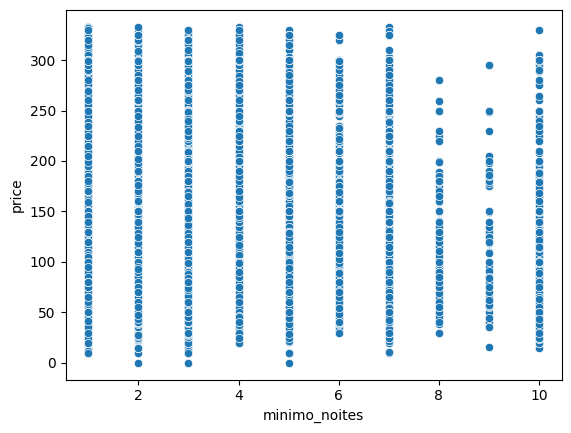

In [23]:
sns.scatterplot(data=df_main, x='minimo_noites', y='price')

#### Relação entre disponibilidade_365 e price

Não parece haver uma forte relação

<Axes: xlabel='disponibilidade_365', ylabel='price'>

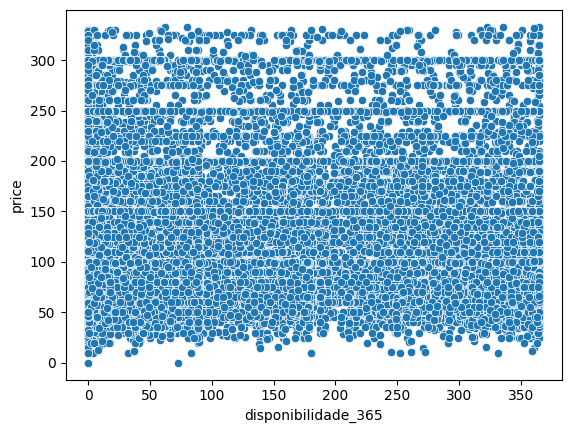

In [24]:
sns.scatterplot(data=df_main, x='disponibilidade_365', y='price')

### Análise de Texto no anúncio

In [25]:
!pip install nltk

#### Importando Bibliotecas

In [26]:
from collections import Counter
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords

#### Carregando Dados

In [27]:
df_text_anuncio = pd.read_csv('teste_indicium_precificacao.csv')

#### Tratando Dados

In [28]:
manter = ['nome', 'price']

for coluna in df_text_anuncio.columns:
    if coluna not in manter:
        df_text_anuncio.drop(coluna, axis=1, inplace=True)

In [29]:
df_text_anuncio['nome'].fillna('unknown', inplace=True)

#### Criando Bigramas e Trigramas

Baixando a lista de palavras para ignorar e o tokenizador

In [30]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pfesc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pfesc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
def create_ngram(nome, n):
    palavras = nltk.word_tokenize(nome.lower()) # transforma o texto em uma lista de palavras
    palavras_p_ignorar = set(stopwords.words('english')) # desconsiderando palavras
    
    # após o primeiro round percebi que | ? * + estavam atrapalhando os trigramas e bigramas por isso:
    palavras_p_ignorar.update({'?', '*', '+', '|', "!"})
    
    palavras = [palavra for palavra in palavras if palavra not in palavras_p_ignorar] # removendo algumas palavras
    return list(ngrams(palavras, n)) #gera brigramas e trigramas que são adiconados as lista 

df_text_anuncio['bigramas'] = df_text_anuncio['nome'].apply(lambda nome: create_ngram(nome, 2))
df_text_anuncio['trigrama'] = df_text_anuncio['nome'].apply(lambda nome: create_ngram(nome, 3))

In [33]:
df_text_anuncio

nome  price  \
0                                  Skylit Midtown Castle    225   
1                    THE VILLAGE OF HARLEM....NEW YORK !    150   
2                        Cozy Entire Floor of Brownstone     89   
3       Entire Apt: Spacious Studio/Loft by central park     80   
4              Large Cozy 1 BR Apartment In Midtown East    200   
...                                                  ...    ...   
48889    Charming one bedroom - newly renovated rowhouse     70   
48890      Affordable room in Bushwick/East Williamsburg     40   
48891            Sunny Studio at Historical Neighborhood    115   
48892               43rd St. Time Square-cozy single bed     55   
48893  Trendy duplex in the very heart of Hell's Kitchen     90   

                                                bigramas  \
0                 [(skylit, midtown), (midtown, castle)]   
1      [(village, harlem), (harlem, ....), (...., new...   
2      [(cozy, entire), (entire, floor), (floor, brow...   
3      [(entire, apt), (apt, :), (:, spacious), (spac...   
4      [(large, cozy), (cozy, 1), (1, br), (br, apart...   
...                                                  ...   
48889  [(charming, one), (one, bedroom), (bedroom, -)...   
48890  [(affordable, room), (room, bushwick/east), (b...   
48891  [(sunny, studio), (studio, historical), (histo...   
48892  [(43rd, st.), (st., time), (time, square-cozy)...   
48893  [(trendy, duplex), (duplex, heart), (heart, he...   

                                                trigrama  
0                            [(skylit, midtown, castle)]  
1      [(village, harlem, ....), (harlem, ...., new),...  
2      [(cozy, entire, floor), (entire, floor, browns...  
3      [(entire, apt, :), (apt, :, spacious), (:, spa...  
4      [(large, cozy, 1), (cozy, 1, br), (1, br, apar...  
...                                                  ...  
48889  [(charming, one, bedroom), (one, bedroom, -), ...  
48890  [(affordable, room, bushwick/east), (room, bus...  
48891  [(sunny, studio, historical), (studio, histori...  
48892  [(43rd, st., time), (st., time, square-cozy), ...  
48893  [(trendy, duplex, heart), (duplex, heart, hell...  

[48894 rows x 4 columns]

Selecionando os anuncios com maiores preços

In [34]:
limite_superior = df_text_anuncio['price'].quantile(0.75)

df_text_anuncio_mais_caro = df_text_anuncio[df_text_anuncio['price'] > limite_superior]

In [35]:
df_text_anuncio_mais_caro

nome  price  \
0                                  Skylit Midtown Castle    225   
4              Large Cozy 1 BR Apartment In Midtown East    200   
15                     Perfect for Your Parents + Garden    215   
18                     Huge 2 BR Upper East  Cental Park    190   
19                      Sweet and Spacious Brooklyn Loft    299   
...                                                  ...    ...   
48852     Sunny&quiet paradise in the WV with open views    202   
48855  Large 3 bed, 2 bath , garden , bbq , all you need    345   
48871                                      Nycity-MyHome    260   
48883        Brooklyn Oasis in the heart of Williamsburg    190   
48885                    Comfy 1 Bedroom in Midtown East    200   

                                                bigramas  \
0                 [(skylit, midtown), (midtown, castle)]   
4      [(large, cozy), (cozy, 1), (1, br), (br, apart...   
15               [(perfect, parents), (parents, garden)]   
18     [(huge, 2), (2, br), (br, upper), (upper, east...   
19     [(sweet, spacious), (spacious, brooklyn), (bro...   
...                                                  ...   
48852  [(sunny, &), (&, quiet), (quiet, paradise), (p...   
48855  [(large, 3), (3, bed), (bed, ,), (,, 2), (2, b...   
48871                                                 []   
48883  [(brooklyn, oasis), (oasis, heart), (heart, wi...   
48885  [(comfy, 1), (1, bedroom), (bedroom, midtown),...   

                                                trigrama  
0                            [(skylit, midtown, castle)]  
4      [(large, cozy, 1), (cozy, 1, br), (1, br, apar...  
15                          [(perfect, parents, garden)]  
18     [(huge, 2, br), (2, br, upper), (br, upper, ea...  
19     [(sweet, spacious, brooklyn), (spacious, brook...  
...                                                  ...  
48852  [(sunny, &, quiet), (&, quiet, paradise), (qui...  
48855  [(large, 3, bed), (3, bed, ,), (bed, ,, 2), (,...  
48871                                                 []  
48883  [(brooklyn, oasis, heart), (oasis, heart, will...  
48885  [(comfy, 1, bedroom), (1, bedroom, midtown), (...  

[12177 rows x 4 columns]

In [36]:
bigramas = [bigrama for bigrama_list in df_text_anuncio_mais_caro['bigramas'] for bigrama in bigrama_list]
trigramas = [trigrama for trigrama_list in df_text_anuncio_mais_caro['trigrama'] for trigrama in trigrama_list]

Contando palavras mais comuns

In [37]:
bigramas_mais_comuns = Counter(bigramas).most_common(20)
trigramas_mais_comuns = Counter(trigramas).most_common(20)

In [38]:
bigramas_mais_comuns

[(('2', 'bedroom'), 501),
 (('1', 'bedroom'), 444),
 (('central', 'park'), 438),
 (('east', 'village'), 419),
 (('west', 'village'), 379),
 (('east', 'side'), 281),
 (('one', 'bedroom'), 266),
 (('times', 'square'), 256),
 (('bedroom', 'apartment'), 252),
 (('3', 'bedroom'), 206),
 (('bedroom', 'apt'), 201),
 (('upper', 'east'), 191),
 (('new', 'york'), 175),
 (('apt', '.'), 172),
 (('2', 'bed'), 158),
 (('sonder', 'stock'), 158),
 (('stock', 'exchange'), 158),
 (('1', 'br'), 152),
 (('park', 'slope'), 150),
 (('2', 'br'), 148)]

In [39]:
trigramas_mais_comuns

[(('sonder', 'stock', 'exchange'), 158),
 (('upper', 'east', 'side'), 153),
 (('lower', 'east', 'side'), 114),
 (('upper', 'west', 'side'), 108),
 (('near', 'central', 'park'), 97),
 (('2', 'bedroom', 'apartment'), 82),
 (('1', 'bedroom', 'apt'), 73),
 (('2', 'bedroom', 'apt'), 68),
 (('new', 'york', 'city'), 65),
 (('1', 'bedroom', 'apartment'), 61),
 (('hell', "'s", 'kitchen'), 59),
 (('wyndham', 'midtown', '45'), 58),
 (('bed', '2', 'bath'), 53),
 (('near', 'times', 'square'), 50),
 (('guest', 'service', 'fee'), 49),
 (('2', 'bed', '2'), 44),
 (('one', 'bedroom', 'apartment'), 39),
 (('heart', 'east', 'village'), 38),
 (('east', 'village', 'apartment'), 37),
 (('heart', 'west', 'village'), 37)]

Essas são as palavras mais comuns para os anúncios de maior preço

## Modelo (catboost)

O catboos será usado pois ele lida automaticamente com variáveis categóricas, como não tenho tantos dados também quero evitar ao máximo overfitting

#### Importando Bibliotecas

In [40]:
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#### Carregando Dados

In [41]:
df_model = pd.read_csv("teste_indicium_precificacao.csv")

In [42]:
df_model.drop(['host_id', 'id', 'nome', 'host_name', 'ultima_review', 'reviews_por_mes'], inplace=True, axis=1)

#### Limpando Dados

In [43]:
df_model.isnull().sum()

bairro_group                     0
bairro                           0
latitude                         0
longitude                        0
room_type                        0
price                            0
minimo_noites                    0
numero_de_reviews                0
calculado_host_listings_count    0
disponibilidade_365              0
dtype: int64

In [44]:
features_categoricas = [feature for feature in df_model.columns if df_model[feature].dtypes == 'object']
features_categoricas

['bairro_group', 'bairro', 'room_type']

No início deste notebbok, foi explicado que a feature price possui em alguns momento valores muito altos, esses valores impedem o bom funcionanmento do modelo, por isso, será criado o seguinte modelo

modelo_1A = para treinar com os dados até o price 334

embora essa não seja a melhor forma de criar o modelo, por causa que ele pode acabar precificando de forma mais barata imóveis/quarto que poderiam ser mais caros, essa foi melhor forma que eu encontrei para se obter uma boa precição

#### Treinando Modelo_1A

In [45]:
df_model_1A = df_model[df_model['price'] <= 337]

In [46]:
x = df_model_1A.drop('price', axis=1)
y = df_model_1A['price']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [47]:
# no momento não estou com tempo, se preicar aumentar a prenisão não esquece de reduzir o learning_rate

modelo_1A = CatBoostRegressor(iterations=5000, depth=8, learning_rate=0.01, verbose=20)

In [48]:
# cuidado com o resultado, fica atento ao early_stopping_rounds pra evitar overfitting

modelo_1A.fit(X_train, y_train, cat_features=features_categoricas, eval_set=(X_test, y_test), early_stopping_rounds=1000)

0:	learn: 67.9114962	test: 67.7362375	best: 67.7362375 (0)	total: 173ms	remaining: 14m 26s
20:	learn: 62.0648444	test: 61.9641571	best: 61.9641571 (20)	total: 1.96s	remaining: 7m 44s
40:	learn: 57.6761889	test: 57.6502545	best: 57.6502545 (40)	total: 3.33s	remaining: 6m 43s
60:	learn: 54.4343195	test: 54.4774401	best: 54.4774401 (60)	total: 4.76s	remaining: 6m 25s
80:	learn: 52.0228965	test: 52.1265685	best: 52.1265685 (80)	total: 6.13s	remaining: 6m 12s
100:	learn: 50.3002130	test: 50.4518974	best: 50.4518974 (100)	total: 8.67s	remaining: 7m
120:	learn: 49.0260873	test: 49.2311768	best: 49.2311768 (120)	total: 10.2s	remaining: 6m 51s
140:	learn: 48.0464012	test: 48.3090031	best: 48.3090031 (140)	total: 12.4s	remaining: 7m 7s
160:	learn: 47.2836283	test: 47.5886914	best: 47.5886914 (160)	total: 14.4s	remaining: 7m 12s
180:	learn: 46.6742471	test: 47.0240888	best: 47.0240888 (180)	total: 16.2s	remaining: 7m 10s
200:	learn: 46.2194198	test: 46.6163459	best: 46.6163459 (200)	total: 18s	re

1740:	learn: 42.3247334	test: 44.4512515	best: 44.4512515 (1740)	total: 2m 42s	remaining: 5m 4s
1760:	learn: 42.3049781	test: 44.4468595	best: 44.4464928 (1752)	total: 2m 46s	remaining: 5m 5s
1780:	learn: 42.2832739	test: 44.4409128	best: 44.4409128 (1780)	total: 2m 49s	remaining: 5m 7s
1800:	learn: 42.2649903	test: 44.4377449	best: 44.4377371 (1799)	total: 2m 52s	remaining: 5m 6s
1820:	learn: 42.2429872	test: 44.4303385	best: 44.4303385 (1820)	total: 2m 54s	remaining: 5m 5s
1840:	learn: 42.2271560	test: 44.4281324	best: 44.4279034 (1838)	total: 2m 57s	remaining: 5m 4s
1860:	learn: 42.2095265	test: 44.4253663	best: 44.4253663 (1860)	total: 3m	remaining: 5m 3s
1880:	learn: 42.1937446	test: 44.4215425	best: 44.4215406 (1879)	total: 3m 2s	remaining: 5m 1s
1900:	learn: 42.1775462	test: 44.4177487	best: 44.4175558 (1899)	total: 3m 4s	remaining: 5m
1920:	learn: 42.1562686	test: 44.4115760	best: 44.4115760 (1920)	total: 3m 7s	remaining: 4m 59s
1940:	learn: 42.1420355	test: 44.4095383	best: 44

3440:	learn: 41.0124982	test: 44.2512683	best: 44.2512683 (3440)	total: 5m 39s	remaining: 2m 33s
3460:	learn: 40.9965945	test: 44.2497504	best: 44.2497504 (3460)	total: 5m 40s	remaining: 2m 31s
3480:	learn: 40.9836134	test: 44.2484860	best: 44.2484860 (3480)	total: 5m 42s	remaining: 2m 29s
3500:	learn: 40.9657451	test: 44.2477146	best: 44.2470786 (3493)	total: 5m 44s	remaining: 2m 27s
3520:	learn: 40.9533070	test: 44.2464160	best: 44.2464007 (3519)	total: 5m 46s	remaining: 2m 25s
3540:	learn: 40.9389064	test: 44.2437866	best: 44.2435255 (3537)	total: 5m 47s	remaining: 2m 23s
3560:	learn: 40.9236121	test: 44.2418339	best: 44.2418098 (3558)	total: 5m 50s	remaining: 2m 21s
3580:	learn: 40.9142685	test: 44.2411474	best: 44.2411474 (3580)	total: 5m 51s	remaining: 2m 19s
3600:	learn: 40.9020309	test: 44.2412961	best: 44.2402000 (3592)	total: 5m 53s	remaining: 2m 17s
3620:	learn: 40.8903635	test: 44.2407260	best: 44.2402000 (3592)	total: 5m 55s	remaining: 2m 15s
3640:	learn: 40.8768133	test: 

In [49]:
pred_model_1A = modelo_1A.predict(X_test)

In [50]:
mean_absolute_error(y_test, pred_model_1A)

31.583229345386183

In [51]:
def modelo(dataframe):
    if isinstance(dataframe, pd.DataFrame):
        dataframe = dataframe.drop(columns=['host_id', 'id', 'nome', 'host_name', 'ultima_review', 'reviews_por_mes'])
    elif isinstance(dataframe, dict):
        for key in ['host_id', 'id', 'nome', 'host_name', 'ultima_review', 'reviews_por_mes']:
            dataframe.pop(key)
        dataframe = pd.DataFrame([dataframe])

    valor = modelo_1A.predict(dataframe)
    return valor

#### Verificando erro fora do intervalo interquatil

Para avaliar o erro do modelo, eu usei a erro médio absoluto, porém também quero haviar da seguinte maneira, considerando um valor, por exemplo 10 (10 sendo a unidade monetária como 10 reais ou dórlares), quanto aluguéis foram previtos com um erro maior ou menor que 10 

In [52]:
erros_model_1A = pd.DataFrame({'erro': y_test - pred_model_1A})

<Axes: >

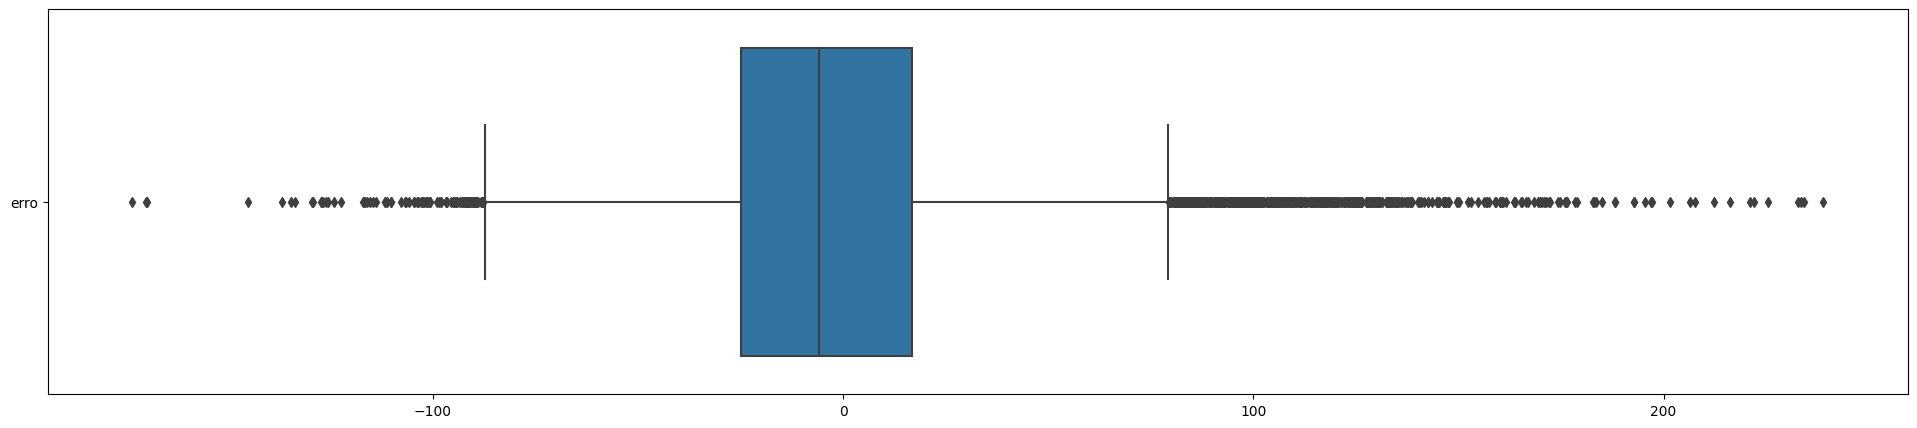

In [53]:
fig = plt.figure(figsize=(24,5))

sns.boxplot(erros_model_1A, orient='h')

In [54]:
Q1 = erros_model_1A['erro'].quantile(0.25)
Q3 = erros_model_1A['erro'].quantile(0.75)

print('Q1:', Q1)
print('Q3:', Q3)

Q1: -24.915422479964732
Q3: 16.762602083806733


In [55]:
pred_errado = erros_model_1A[(erros_model_1A['erro'] < -10) | (erros_model_1A['erro'] > 10)].count()
qtde = erros_model_1A.shape[0]

print(f'Quantidade de linhas previstas: {qtde}')
print(f'Quantidade de linhas previstas com mais de 10: {pred_errado[0]}')
print(f'% previsto com mais de 10: {((pred_errado[0]/qtde)*100).round(2)}%')

Quantidade de linhas previstas: 9187
Quantidade de linhas previstas com mais de 10: 6867
% previsto com mais de 10: 74.75%


In [56]:
pred_errado = erros_model_1A[(erros_model_1A['erro'] < -15) | (erros_model_1A['erro'] > 15)].count()
qtde = erros_model_1A.shape[0]

print(f'Quantidade de linhas previtas: {qtde}')
print(f'Quantidade de linhas previtas com mais de 15: {pred_errado[0]}')
print(f'% previsto com mais de 15: {((pred_errado[0]/qtde)*100).round(2)}%')

Quantidade de linhas previtas: 9187
Quantidade de linhas previtas com mais de 15: 5842
% previsto com mais de 15: 63.59%


#### Prevendo alguél com características informadas pela Indicium

In [57]:
prever_alug = pd.DataFrame([{'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}])

In [58]:
sug_price = modelo(prever_alug)

In [59]:
# preço sugerido

sug_price

array([209.04105713])

### Salvando o Modelo no Formato .pkl

#### Importando biblioteca

In [60]:
import pickle

In [61]:
with open('modelo_1A.pkl', 'wb') as file:
    pickle.dump(modelo, file)

#### Testando o modelo_1A.pkl

In [62]:
with open('modelo_1A.pkl', 'rb') as file:
    modelo_para_prev = pickle.load(file)

In [63]:
modelo_para_prev(prever_alug)

array([209.04105713])

In [65]:
!pip freeze > requirements.txt